In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd
from shapely import from_wkb
import sys
sys.path.append("../")
from construct_graph.spectral_equal_size_clustering import SpectralEqualSizeClustering
import math

import matplotlib.pyplot as plt

In [2]:
data_folder = Path("/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022")

city = "melbourne"

# city_road_graph_folder = data_folder / "road_graph" / city
road_filtered_file = data_folder / "adj" / city / "road_filtered_with_id.parquet"
adj_file = data_folder / "adj" / city / "adjacency_mat_filtered.csv"

EPSG = {
    "melbourne": "28355",
    "madrid": "2062",
    "london": "27700"
}

In [3]:
# Load road information
road = pd.read_parquet(road_filtered_file)
road["geometry"] = road["geometry"].apply(lambda x:from_wkb(x))
road = gpd.GeoDataFrame(road, geometry=road["geometry"], crs="4326")

/var/folders/ck/54lvx0lx09162my4wjpgkjz40000gp/T/ipykernel_32006/2568972883.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = np.array([[c.x, c.y] for c in road.centroid.to_crs(EPSG[city.split("_")[0]])])
/opt/miniconda3/envs/mets-10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 2 3 4 5 6]
[90 30 50 32 40 52 56]


<Axes: >

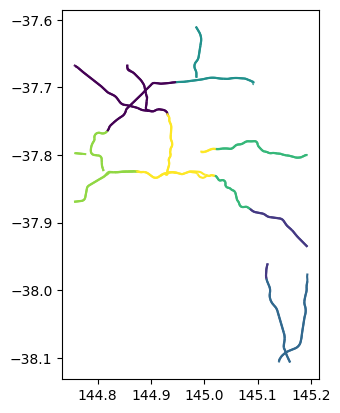

In [4]:
# Partition road by KNN
from sklearn import cluster
centroid = np.array([[c.x, c.y] for c in road.centroid.to_crs(EPSG[city.split("_")[0]])])
km = cluster.KMeans(n_clusters=7)
partition = km.fit(centroid)

# Partition results
l, c = np.unique(partition.labels_,return_counts=True)
print(f"{l}\n{c}")

road["km_label"] = partition.labels_
road.plot(column="km_label")

In [5]:
def pure_dist():
    from scipy.spatial.distance import cdist
    dist_tr = cdist(centroid, centroid)
    return dist_tr

def by_adj_weight(delta=0.2):
    with open(data_folder / "adj" / city / "adjacency_mat_filtered.npy","rb") as f:
        adj= np.load(f)
    node_num = adj[:,:2].max()+1
    dist_max = adj[:,-1].max()
    delta = dist_max*(1+delta)
    dist_tr = np.zeros((node_num,node_num))
    np.fill_diagonal(dist_tr, sim_to_dist(0, delta=delta))
    for i in range(adj.shape[0]):
            dist_tr[adj[i,0],adj[i,1]] = sim_to_dist(adj[i,2], delta=delta)
            dist_tr[adj[i,1],adj[i,0]] = sim_to_dist(adj[i,2], delta=delta)
#     dist_tr = sim_to_dist(dist_tr)
    return dist_tr

def by_adj():
    dist_tr = pd.read_csv(adj_file, header=None).values
    dist_tr = sim_to_dist(dist_tr,0.01)
    return dist_tr

def sim_to_dist(dist_matrix, delta=1000):
    return np.exp(- dist_matrix ** 2 / (2. * delta ** 2))

INFO:root:parameters of the cluster: nclusters: (7,) equity_fr: 0.9 nneighbours: 17
INFO:root:ideal elements per cluster: [50, 50, 50, 50, 50, 50, 50]
INFO:root:min-max range of elements: 45.0-55.00000000000001
INFO:root:parameters of the cluster: nclusters: (7,) equity_fr: 0.9 nneighbours: 35
INFO:root:ideal elements per cluster: [50, 50, 50, 50, 50, 50, 50]
INFO:root:min-max range of elements: 45.0-55.00000000000001
INFO:root:parameters of the cluster: nclusters: (7,) equity_fr: 0.9 nneighbours: 52
INFO:root:ideal elements per cluster: [50, 50, 50, 50, 50, 50, 50]
INFO:root:min-max range of elements: 45.0-55.00000000000001
INFO:root:parameters of the cluster: nclusters: (7,) equity_fr: 0.9 nneighbours: 70
INFO:root:ideal elements per cluster: [50, 50, 50, 50, 50, 50, 50]
INFO:root:min-max range of elements: 45.0-55.00000000000001
INFO:root:parameters of the cluster: nclusters: (7,) equity_fr: 0.9 nneighbours: 70
INFO:root:ideal elements per cluster: [50, 50, 50, 50, 50, 50, 50]
INFO:

[29857.14421973258, 26798.904336032865, 24491.301925570042, 22986.826923202207]
Proper NEIGHBOR = 0.2
[0 1 2 3 4 5 6]
[45 56 32 49 56 62 50]


<Axes: >

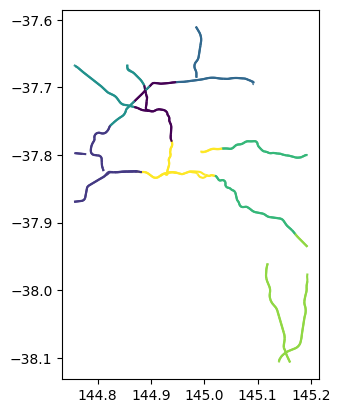

In [6]:
# Partition by Spectral Equal Size
EQUITY_FRACTION = 0.9 # a fraction that determines how equal in size the clusters must be
NEIGHBORS = [0.05,0.1,.15,.2] # the number of neighbors per data point to be changed for equal size
NSIZE = 50

# Symmetric distance matrix
dist_tr = pure_dist()

# Get the cluster hyperparameters
ncluster = int(math.floor(dist_tr.shape[0] / NSIZE))

# GRID SEARCH
disp = []
for NEIGHBOR in NEIGHBORS:
    clustering = SpectralEqualSizeClustering(nclusters=ncluster,
                                             nneighbors=int(dist_tr.shape[0] * NEIGHBOR),
                                             equity_fraction=EQUITY_FRACTION,
                                             seed=1234)

    labels = clustering.fit(dist_tr)
    # TODO: Use adj as objective function (consider connectivity)
    disp.append(clustering.total_cluster_dispersion)
NEIGHBOR = NEIGHBORS[np.argmin(np.array(disp))]
print(disp)
print(f"Proper NEIGHBOR = {NEIGHBOR}")

# Fit
clustering = SpectralEqualSizeClustering(nclusters=ncluster,
                                             nneighbors=int(dist_tr.shape[0] * NEIGHBOR),
                                             equity_fraction=EQUITY_FRACTION,
                                             seed=1234)

labels = clustering.fit(dist_tr)
    
# Partition results
l, c = np.unique(labels,return_counts=True)
print(f"{l}\n{c}")

road["sp_label"] = labels
road.plot(column="sp_label")

In [190]:
road.head()

,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,...,t,road_index,id_highway,name,geometry,id_name,id_lanes,id_maxspeed,km_label,sp_label
0,99937,25470798,18769878,32.2,20 mph,trunk,True,3,nan,89.617,...,84,0,1,MaryleboneRoad,"LINESTRING (-0.15202 51.52302, -0.15221 51.523...",8705351563198506287,3,20,1,11
1,102047,4706034993,8114019,32.2,20 mph,trunk,True,2,nan,143.178,...,85,1,1,EdgwareRoad,"LINESTRING (-0.16071 51.51316, -0.16063 51.513...",3984855555459660334,2,20,1,11
2,102047,27503594,43407796,32.2,20 mph,primary,True,4,nan,58.022,...,93,2,2,BayswaterRoad,"LINESTRING (-0.16071 51.51316, -0.16039 51.513...",5758949736977383531,4,20,1,11
3,102052,102057,"[41517345, 808613233, 42709091]",32.2,20 mph,trunk,True,3,nan,130.939,...,87,3,1,CumberlandGate,"LINESTRING (-0.15889 51.51260, -0.15912 51.512...",-3518910808041885797,3,20,1,11
4,102053,25471268,239011228,32.2,20 mph,trunk,True,4,nan,32.251,...,86,4,1,ParkLane,"LINESTRING (-0.15818 51.51298, -0.15809 51.512...",-2212220094948102868,4,20,1,11


In [7]:
# save results
road.to_parquet(road_filtered_file)

In [8]:
ld = pd.read_parquet("/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022/adj/melbourne/road_filtered_with_id.parquet")

In [9]:
ld.head()

,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,...,gkey_duplicate,id_lanes,id_maxspeed,road_index,id_highway,name,geometry,id_name,km_label,sp_label
0,21578145,683094366,"[484854832, 28119418, 1083073387, 775968519]",80.0,80,motorway,True,"['4', '3']",nan,1827.578,...,False,4,80,0,0,WestGateFreeway,"b""\x01\x02\x00\x00\x00\x19\x00\x00\x00\xfc\xe8...",7436462973700073041,6,6
1,25635393,8568243422,"[485049160, 4880010, 23034448, 23034447]",100.0,100,motorway,True,3,nan,1307.194,...,False,3,100,1,0,MetropolitanRingRoad,b'\x01\x02\x00\x00\x00\x07\x00\x00\x00t9o\xad@...,-484206589433458560,3,2
2,25635395,25635396,"[485049163, 23229660, 23034437]",100.0,100,motorway,True,"['4', '5']",nan,957.394,...,False,5,100,2,0,MetropolitanRingRoad,b'\x01\x02\x00\x00\x00\x05\x00\x00\x00\xd4\xeb...,-484206589433458560,3,2
3,25635396,3510048622,"[485049154, 485049155, 24608420]",100.0,100,motorway,True,3,nan,1842.292,...,False,3,100,3,0,"['MetropolitanRingRoad','WesternRingRoad']","b""\x01\x02\x00\x00\x00\x11\x00\x00\x00=\xe7\xb...",1022683586519050414,3,2
4,25635400,248509179,"[675058320, 390346763, 25822677, 257043664]",100.0,100,motorway,True,"['2', '4', '3']",nan,3776.382,...,False,4,100,4,0,HumeFreeway,"b""\x01\x02\x00\x00\x00D\x00\x00\x00\xcc\x1c\xd...",1277494209110980998,3,2
